In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import wandb

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn
from tqdm import tqdm
from torch.utils.data import DataLoader


#set up default cuda device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
device = 'cuda:0'

download_url = 'https://i2dl.vc.in.tum.de/static/data/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')

download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

def train_model(epochs: int, train_loader: DataLoader, val_loader: DataLoader, model: torch.nn.Module, loss_func: torch.nn.Module, optimizer: torch.optim.Optimizer) -> torch.nn.Module:
    model = model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        training_loss = 0.0


        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            images, targets = batch
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = loss_func(preds, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        

        torch.cuda.empty_cache()

       # Validation phase
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                images, targets = batch
                images, targets = images.to(device), targets.to(device)
                preds = model(images)
                loss = loss_func(preds, targets)
                validation_loss += loss.item()
            

        # Calculate average losses
        train_loss = training_loss / len(train_loader)
        val_loss = validation_loss / len(val_loader)
        print(f'EPOCH [{epoch + 1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Log the metrics to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
        })

    print('done')
    return model

# Hyperparameters
hparams = {
    'epochs': 60,
    'batch_size': 15,
    'learning_rate': 3e-4,
    'padding' : 1, 
    'stride_down' : 1,
    'stride_up' : 2
}

# Initialize wandb
wandb.init(
    project="my-awesome-project",
    config=hparams
)
wandb.config.learning_rate = hparams['learning_rate']
wandb.config.batch_size = hparams['batch_size']
wandb.config.epochs= hparams['epochs']

# Initialize model, optimizer, loss function, and data loaders
model = SegmentationNN(hp = hparams)
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])

# Datasets
train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

train_loader = DataLoader(train_data, batch_size=hparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_data, batch_size=hparams['batch_size'], shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)

# Loss function 
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

# Train the model
model = train_model(hparams['epochs'], train_loader, val_loader, model, loss_func, optimizer)


os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")







epoch,▁▂▃▄▅▅▆▇█
train_loss,█▆▅▄▃▂▂▂▁
val_loss,█▆▄▃▂▂▁▂▁
epoch,9
train_loss,2.04087
val_loss,1.95669


Validation Epoch 1/70: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


EPOCH [1/70], Training Loss: 2.8149, Validation Loss: 2.8562


Validation Epoch 2/70: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


EPOCH [2/70], Training Loss: 2.4085, Validation Loss: 2.4109


Validation Epoch 3/70: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


EPOCH [3/70], Training Loss: 2.3144, Validation Loss: 2.2170


Validation Epoch 4/70: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


EPOCH [4/70], Training Loss: 2.2216, Validation Loss: 2.2378


Validation Epoch 5/70: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


EPOCH [5/70], Training Loss: 2.1707, Validation Loss: 2.2723


Validation Epoch 6/70: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


EPOCH [6/70], Training Loss: 2.1144, Validation Loss: 2.1862


Validation Epoch 7/70: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


EPOCH [7/70], Training Loss: 2.0218, Validation Loss: 1.9162


Validation Epoch 8/70: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


EPOCH [8/70], Training Loss: 1.9734, Validation Loss: 1.8826


Validation Epoch 9/70: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


EPOCH [9/70], Training Loss: 1.9621, Validation Loss: 1.8863


Validation Epoch 10/70: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


EPOCH [10/70], Training Loss: 1.9481, Validation Loss: 1.9758


Validation Epoch 11/70: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


EPOCH [11/70], Training Loss: 1.9200, Validation Loss: 1.9555


Validation Epoch 12/70: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


EPOCH [12/70], Training Loss: 1.9046, Validation Loss: 1.7599


Validation Epoch 13/70: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


EPOCH [13/70], Training Loss: 1.8268, Validation Loss: 1.7242


Validation Epoch 14/70: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


EPOCH [14/70], Training Loss: 1.8021, Validation Loss: 1.6342


Validation Epoch 15/70: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


EPOCH [15/70], Training Loss: 1.7353, Validation Loss: 1.7482


Validation Epoch 16/70: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


EPOCH [16/70], Training Loss: 1.7874, Validation Loss: 1.6546


Validation Epoch 17/70: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


EPOCH [17/70], Training Loss: 1.7529, Validation Loss: 1.8203


Validation Epoch 18/70: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]


EPOCH [18/70], Training Loss: 1.7284, Validation Loss: 1.7351


Validation Epoch 19/70: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


EPOCH [19/70], Training Loss: 1.7062, Validation Loss: 1.7207


Validation Epoch 20/70: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


EPOCH [20/70], Training Loss: 1.6754, Validation Loss: 1.6445


Validation Epoch 21/70: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


EPOCH [21/70], Training Loss: 1.6585, Validation Loss: 1.7155


Validation Epoch 22/70: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


EPOCH [22/70], Training Loss: 1.5670, Validation Loss: 1.5832


Validation Epoch 23/70: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


EPOCH [23/70], Training Loss: 1.5686, Validation Loss: 1.5939


Validation Epoch 24/70: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


EPOCH [24/70], Training Loss: 1.5867, Validation Loss: 1.6231


Validation Epoch 25/70: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


EPOCH [25/70], Training Loss: 1.5357, Validation Loss: 1.6691


Validation Epoch 26/70: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


EPOCH [26/70], Training Loss: 1.5174, Validation Loss: 1.5599


Validation Epoch 27/70: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


EPOCH [27/70], Training Loss: 1.4775, Validation Loss: 1.4411


Validation Epoch 28/70: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


EPOCH [28/70], Training Loss: 1.4858, Validation Loss: 1.4572


Validation Epoch 29/70: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


EPOCH [29/70], Training Loss: 1.4292, Validation Loss: 1.4999


Validation Epoch 30/70: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


EPOCH [30/70], Training Loss: 1.3445, Validation Loss: 1.4071


Validation Epoch 31/70: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


EPOCH [31/70], Training Loss: 1.4169, Validation Loss: 1.3741


Validation Epoch 32/70: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


EPOCH [32/70], Training Loss: 1.3917, Validation Loss: 1.3903


Validation Epoch 33/70: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


EPOCH [33/70], Training Loss: 1.4036, Validation Loss: 1.5110


Validation Epoch 34/70: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


EPOCH [34/70], Training Loss: 1.3421, Validation Loss: 1.3903


Validation Epoch 35/70: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


EPOCH [35/70], Training Loss: 1.3215, Validation Loss: 1.4252


Validation Epoch 36/70: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


EPOCH [36/70], Training Loss: 1.3261, Validation Loss: 1.4451


Validation Epoch 37/70: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


EPOCH [37/70], Training Loss: 1.2887, Validation Loss: 1.3989


Validation Epoch 38/70: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


EPOCH [38/70], Training Loss: 1.2629, Validation Loss: 1.3102


Validation Epoch 39/70: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


EPOCH [39/70], Training Loss: 1.2630, Validation Loss: 1.4339


Validation Epoch 40/70: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


EPOCH [40/70], Training Loss: 1.2375, Validation Loss: 1.2315


Validation Epoch 41/70: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


EPOCH [41/70], Training Loss: 1.2433, Validation Loss: 1.2922


Validation Epoch 42/70: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


EPOCH [42/70], Training Loss: 1.2282, Validation Loss: 1.2384


Validation Epoch 43/70: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


EPOCH [43/70], Training Loss: 1.1996, Validation Loss: 1.3595


Validation Epoch 44/70: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


EPOCH [44/70], Training Loss: 1.2138, Validation Loss: 1.7966


Validation Epoch 45/70: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


EPOCH [45/70], Training Loss: 1.2803, Validation Loss: 1.4900


Validation Epoch 46/70: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


EPOCH [46/70], Training Loss: 1.1780, Validation Loss: 1.2973


Validation Epoch 47/70: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


EPOCH [47/70], Training Loss: 1.1808, Validation Loss: 1.2628


Validation Epoch 48/70: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


EPOCH [48/70], Training Loss: 1.1534, Validation Loss: 1.3517


Validation Epoch 49/70: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


EPOCH [49/70], Training Loss: 1.1216, Validation Loss: 1.4659


Validation Epoch 50/70: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


EPOCH [50/70], Training Loss: 1.0743, Validation Loss: 1.3588


Validation Epoch 51/70: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


EPOCH [51/70], Training Loss: 1.0522, Validation Loss: 1.1958


Validation Epoch 52/70: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


EPOCH [52/70], Training Loss: 1.0860, Validation Loss: 1.4060


Validation Epoch 53/70: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


EPOCH [53/70], Training Loss: 1.0936, Validation Loss: 1.1915


Validation Epoch 54/70: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


EPOCH [54/70], Training Loss: 1.1159, Validation Loss: 1.6661


Validation Epoch 55/70: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


EPOCH [55/70], Training Loss: 1.0823, Validation Loss: 1.2462


Validation Epoch 56/70: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


EPOCH [56/70], Training Loss: 1.0750, Validation Loss: 1.3251


Validation Epoch 57/70: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


EPOCH [57/70], Training Loss: 1.0574, Validation Loss: 1.3145


Validation Epoch 58/70: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


EPOCH [58/70], Training Loss: 1.0548, Validation Loss: 1.1428


Validation Epoch 59/70: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


EPOCH [59/70], Training Loss: 1.0457, Validation Loss: 1.3334


Validation Epoch 60/70: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


EPOCH [60/70], Training Loss: 1.0550, Validation Loss: 1.2871


Validation Epoch 61/70: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


EPOCH [61/70], Training Loss: 1.0058, Validation Loss: 1.2752


Validation Epoch 62/70: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


EPOCH [62/70], Training Loss: 0.9788, Validation Loss: 1.3102


Validation Epoch 63/70: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


EPOCH [63/70], Training Loss: 0.9933, Validation Loss: 1.1753


Validation Epoch 64/70: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


EPOCH [64/70], Training Loss: 1.0897, Validation Loss: 1.1440


Validation Epoch 65/70: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


EPOCH [65/70], Training Loss: 1.0501, Validation Loss: 1.1635


Validation Epoch 66/70: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


EPOCH [66/70], Training Loss: 1.0402, Validation Loss: 1.0761


Validation Epoch 67/70: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


EPOCH [67/70], Training Loss: 0.9664, Validation Loss: 1.2981


Validation Epoch 68/70: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


EPOCH [68/70], Training Loss: 0.9927, Validation Loss: 1.1103


Validation Epoch 69/70: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


EPOCH [69/70], Training Loss: 0.9610, Validation Loss: 1.1203


Validation Epoch 70/70: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

EPOCH [70/70], Training Loss: 0.9754, Validation Loss: 1.1155
done


'models/segmentation_nn.model'

In [3]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    model = model.to(device)
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = (targets >= 0).cpu()
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)


model.to(torch.device('cuda'))
device = torch.device('cuda')
test(evaluate_model(model, test_loader))



Validation-Accuracy: 62.35482498321605%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


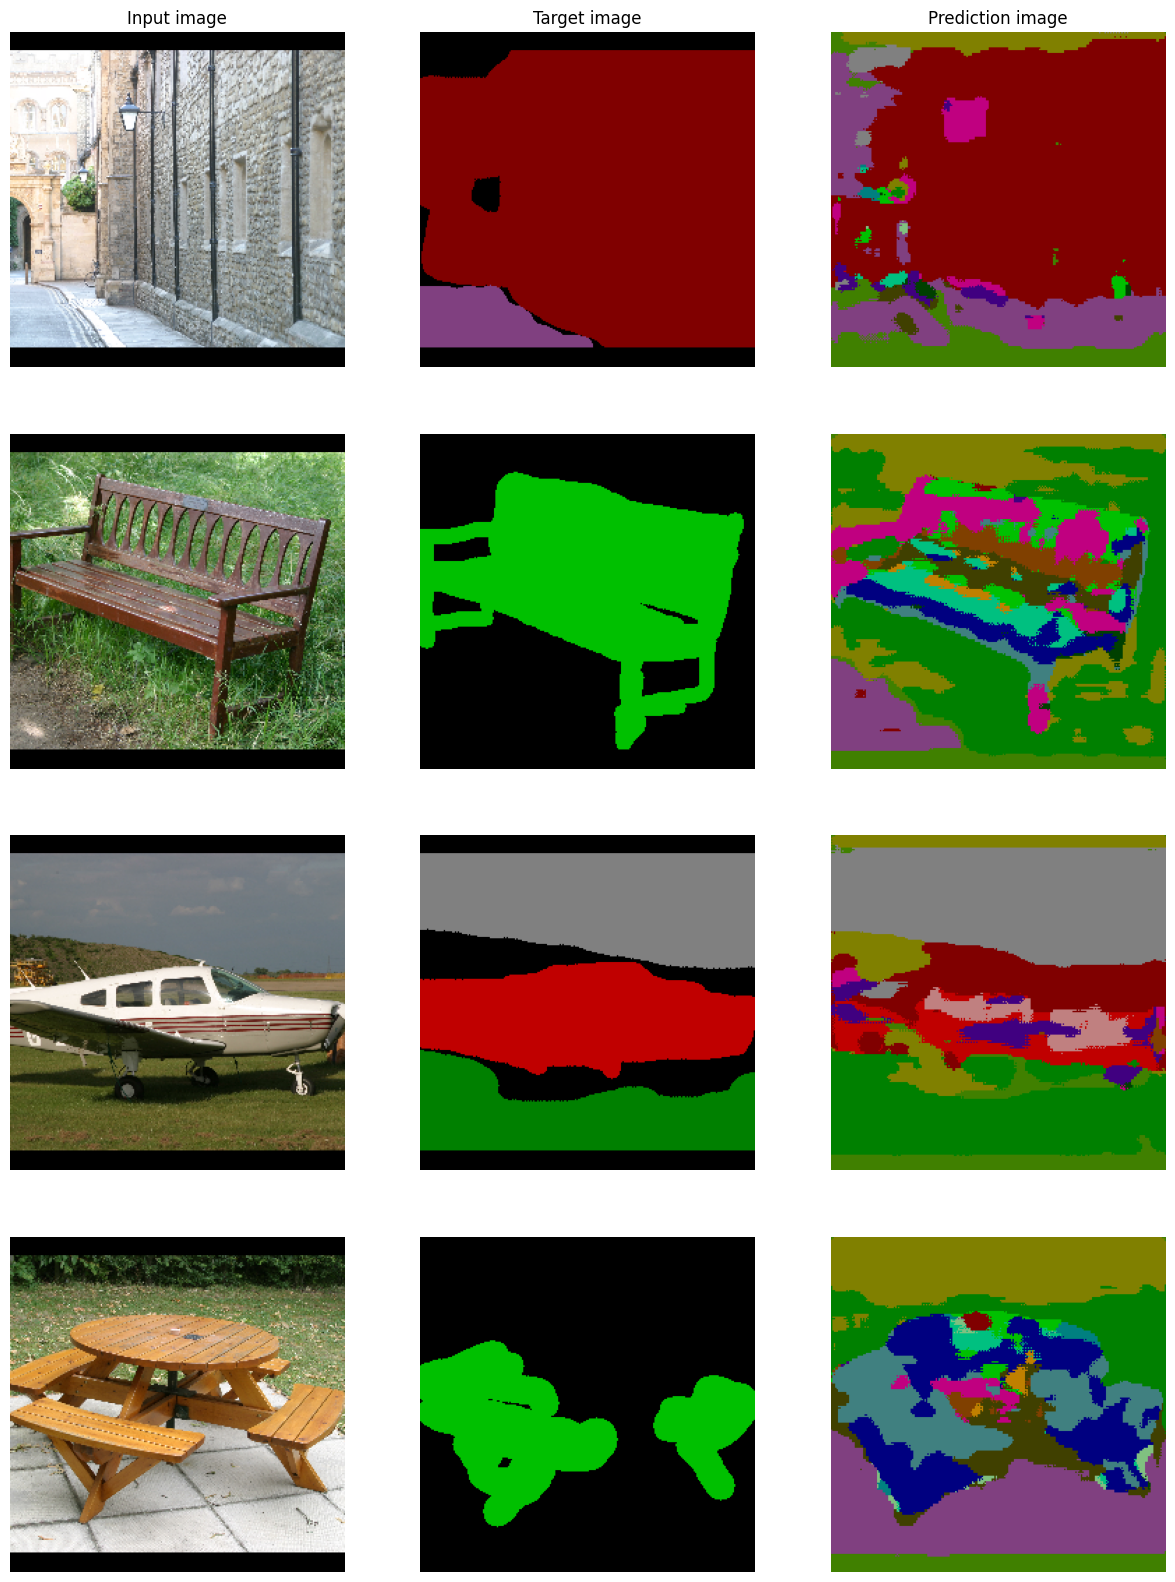

In [4]:

visualizer(model, test_data)

In [5]:
from exercise_code.util.submit import submit_exercise

submit_exercise('../output/exercise10')

relevant folders: ['models', 'exercise_code']
notebooks files: ['main.ipynb', '1_segmentation_nn.ipynb']
Adding folder models
Adding folder exercise_code
Adding notebook main.ipynb
Adding notebook 1_segmentation_nn.ipynb
Zipping successful! Zip is stored under: /home/ali/tum/i2dl/exercise/i2dl/output/exercise10.zip
